In [6]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 250)
plt.rcParams.update({'figure.max_open_warning': 0})
%matplotlib inline
import seaborn as sns
# To check whether a column is numeric type
from pandas.api.types import is_numeric_dtype
# # To check whether a column is object/string type
from pandas.api.types import is_string_dtype

In [7]:
raw_data_file = 'assets/Pit_Stop_Locations.csv'
df = pd.read_csv(raw_data_file)

In [8]:
# Memory Usage Analysis
# If from url, then skip file size in disk check

if "http" in raw_data_file:
    file_size = float('nan')
else:
    # Calculating file size (in MB) on disk
    import os

    file_size = (os.stat(raw_data_file).st_size / 1024 **2)
    

In [9]:
# Calculate dataset size in memory (MB)
df_mem = df.memory_usage(deep=True).sum() / 1024**2

In [10]:

# Calclulate dataset size increase in memory (MB)
sz_increase = ((df_mem - file_size) / file_size)

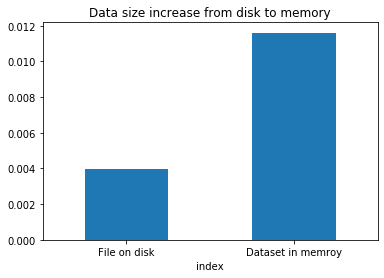

In [20]:
# Create a dictionary from the variables and convert to Pandas DataFrame
# Use DataFrame's ploting capabilities
raw_data_dict = {"File on disk":file_size, "Dataset in memroy": df_mem}
raw_data_plot = pd.DataFrame.from_dict(raw_data_dict, orient='index').reset_index()

# Pandas DataFrame plot
raw_data_plot.plot(kind='bar',\
                   x="index" ,\
                   y=0, \
                   legend=False, \
                   title='Data size increase from disk to memory')
# plt.subplots_adjust(wspace=0.4, hspace=0.35)
plt.xticks(rotation=0)

# Save the figure
plt.show()
#plt.savefig('fig_df_tot_memory.png', dpi=50)
plt.close('all')

In [21]:

# Get memory used by each column in the raw data dataset in MB
mem_used_dtypes = pd.DataFrame(df.memory_usage(deep=True) / 1024**2)

# Rename column
mem_used_dtypes.rename(columns={ 0:'memory'}, inplace=True)

# Drop index memory usage since this is not required when merging with Data Quality Dataframe
mem_used_dtypes.drop('Index', axis=0, inplace=True)

In [22]:
# Constructing the Data_Profiler

# Since it there will be one row for each column
no_of_rows = len(df.columns)


# Constructing the data_qlt_df dataframe and pre-assigning and columns
# Pre-assigning the number of rows the dataframe would have is memory and processing efficient
# This is a better approach than continuous append or concat operation to dataframe

data_qlt_df = pd.DataFrame(index=np.arange(0, no_of_rows), \
                            columns=('column_name', 'col_data_type', 'col_memory','non_null_values', \
                                     'unique_values_count', 'column_dtype')
                          )


# Add rows to the data_qlt_df dataframe
for ind, cols in enumerate(df.columns):
    # Count of unique values in the column
    col_unique_count = df[cols].nunique()
    
    data_qlt_df.loc[ind] = [cols, \
                            df[cols].dtype, \
                            mem_used_dtypes['memory'][ind], \
                            df[cols].count(), \
                            col_unique_count, \
                            cols + '~'+ str(df[cols].dtype)
                            ]

In [23]:
# Getting column descriptive statistics:
raw_num_df = df.describe().T.round(2)

In [24]:
# Merging the df.describe() output with rest of the info to create a single Data Profile Dataframe
data_qlt_df = pd.merge(data_qlt_df, raw_num_df, how='left', left_on='column_name', right_index=True)

In [25]:
# Calculate percentage of non-null values over total number of values
data_qlt_df['%_of_non_nulls'] = (data_qlt_df['non_null_values']/df.shape[0])*100

# Calculate null values for the column
data_qlt_df['null_values'] = df.shape[0] - data_qlt_df['non_null_values']

# Calculate percentage of null values over total number of values
data_qlt_df['%_of_nulls'] = 100 - data_qlt_df['%_of_non_nulls']

# Calculate percentage of each column memory usage compared to total memory used by raw data datframe
data_qlt_df['%_of_total_memory'] = data_qlt_df['col_memory'] / data_qlt_df['col_memory'].sum() * 100

# Calculate the total memory used by a given group of data type
data_qlt_df["dtype_total"] = data_qlt_df.groupby('col_data_type')["col_memory"].transform('sum')

data_qlt_df["%_of_dtype_mem"] = data_qlt_df["col_memory"] / data_qlt_df["dtype_total"] * 100

# Calculate the percentage memory used by each group of data type of the total memory used by dataset
data_qlt_df["dtype_%_total_mem"] = data_qlt_df["dtype_total"] / df_mem * 100

# Calculate the count of each data type
data_qlt_df["dtype_count"] = data_qlt_df.groupby('col_data_type')["col_data_type"].transform('count')

# Calculate the total count of column values
data_qlt_df["count"] = data_qlt_df['null_values'] + data_qlt_df['non_null_values']

In [26]:
data_qlt_df = data_qlt_df[
                            ['column_name', 'col_data_type', 'col_memory', '%_of_dtype_mem', '%_of_total_memory',\
                             'dtype_count', 'dtype_total', 'dtype_%_total_mem', 'non_null_values', '%_of_non_nulls',\
                             'null_values', '%_of_nulls', 'unique_values_count', 'count', 'mean', 'std', 'min', '25%',\
                             '50%', '75%', 'max']
                         ]

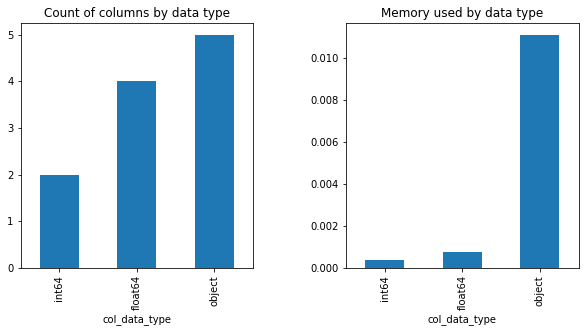

In [27]:

# Plot count of column data types and memory used by each datatype
plt_dtype = data_qlt_df.groupby('col_data_type')['dtype_count', 'dtype_total', 'dtype_%_total_mem'].last().sort_values(by='dtype_count')

fig1, (ax, ax2) = plt.subplots(ncols=2, figsize=(10,5))
plt.subplots_adjust(wspace=0.4, hspace=0.35, bottom=0.20)

plt_dtype.plot(kind='bar', y='dtype_count',  use_index=True, legend=False, ax=ax, title='Count of columns by data type')

plt_dtype.plot(kind='bar', y='dtype_total',  use_index=True, legend=False, ax=ax2, title='Memory used by data type')
plt.show()
#fig1.savefig("fig_cols_memory.png", dpi=50)
plt.close('all')

In [30]:
## Visualizing and ploting Memory Usage Analysis for the Dataset

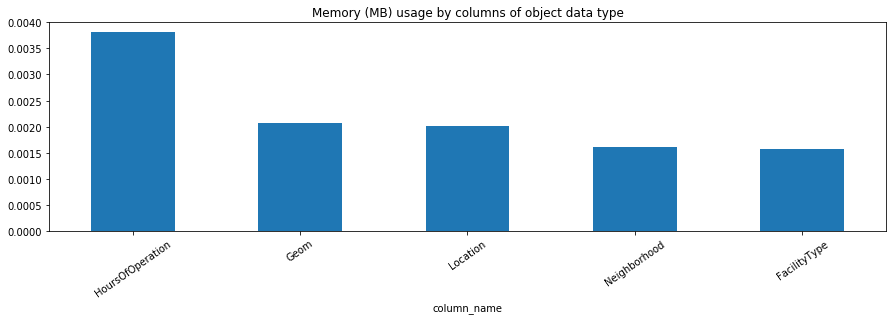

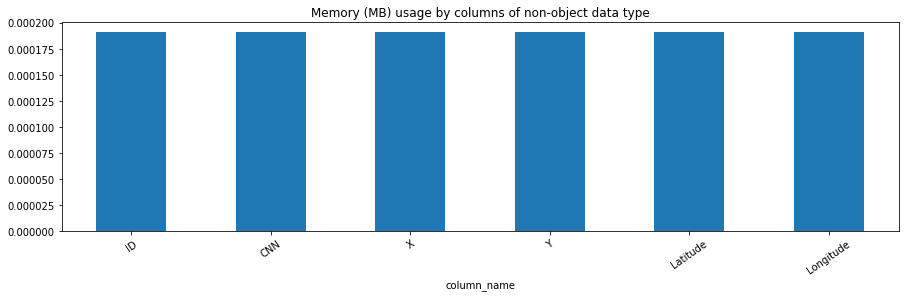

In [31]:
# Memory used by columns of raw data dataframe
fig2, ax = plt.subplots(ncols=1, figsize=(15,5))
plt.subplots_adjust(wspace=0.4, hspace=0.35, bottom=0.30)

# Memory used by object data type
(data_qlt_df[data_qlt_df['col_data_type'] == 'object']
 .sort_values(by='col_memory', ascending=False)
 .plot(kind="bar", 
       x="column_name", 
       y="col_memory", 
       title="Memory (MB) usage by columns of object data type",
      legend=False, ax=ax)
)
plt.xticks(rotation=35)
plt.show()
#fig2.savefig("fig_object_cols_memory.png", dpi=50)
plt.close('all')

# Memory used by non-object data type
fig2, ax1 = plt.subplots(ncols=1, figsize=(15,5))
plt.subplots_adjust(wspace=0.4, hspace=0.35, bottom=0.30)

(data_qlt_df[data_qlt_df['col_data_type'] != 'object']
 .sort_values(by='col_memory', ascending=False)
 .plot(kind="bar", 
       x="column_name", 
       y="col_memory", 
       title="Memory (MB) usage by columns of non-object data type",
      legend=False, ax=ax1)
)
plt.xticks(rotation=35)
plt.show()
#fig2.savefig("fig_non_object_cols_memory.png", dpi=50)
plt.close('all')

1  of  5  completed    Neighborhood
2  of  5  completed    Location
3  of  5  completed    HoursOfOperation
4  of  5  completed    FacilityType
5  of  5  completed    Geom


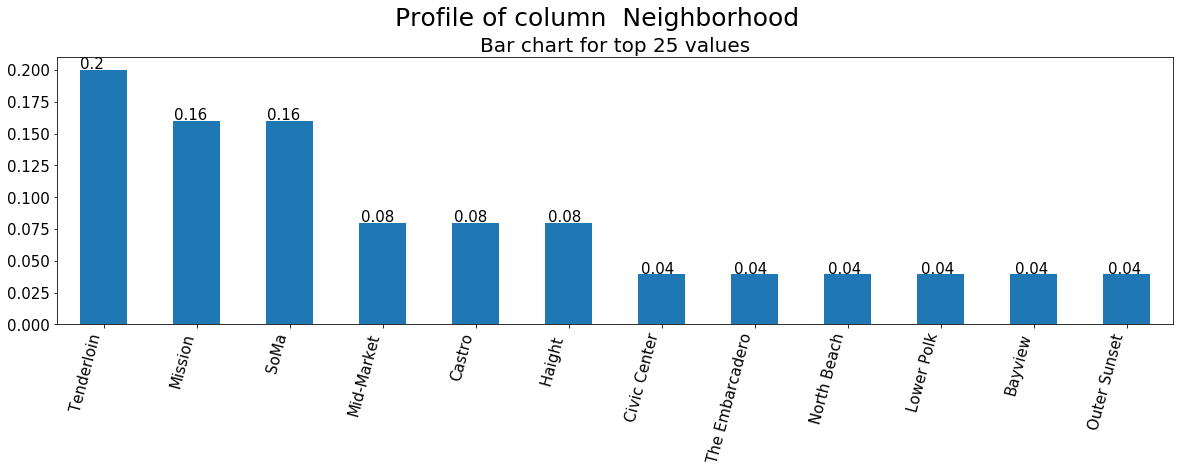

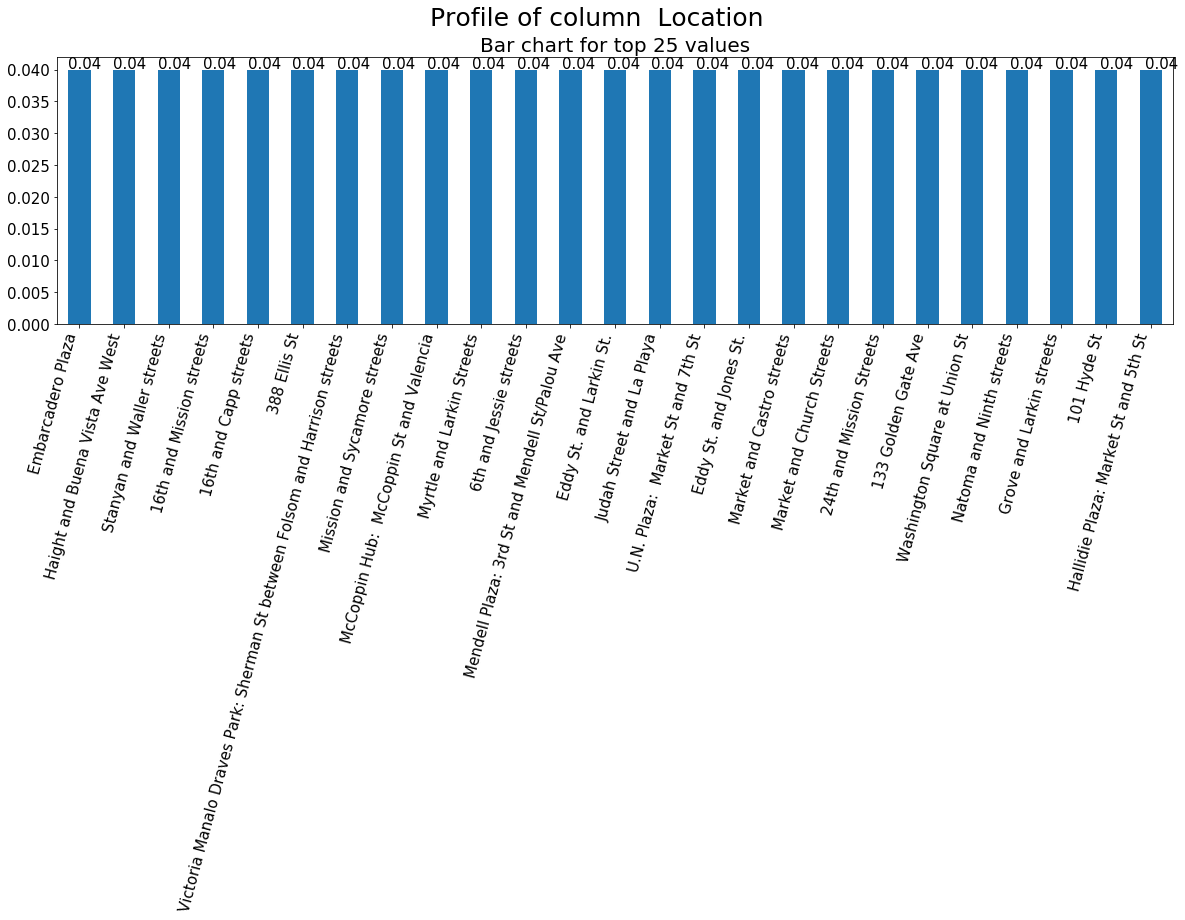

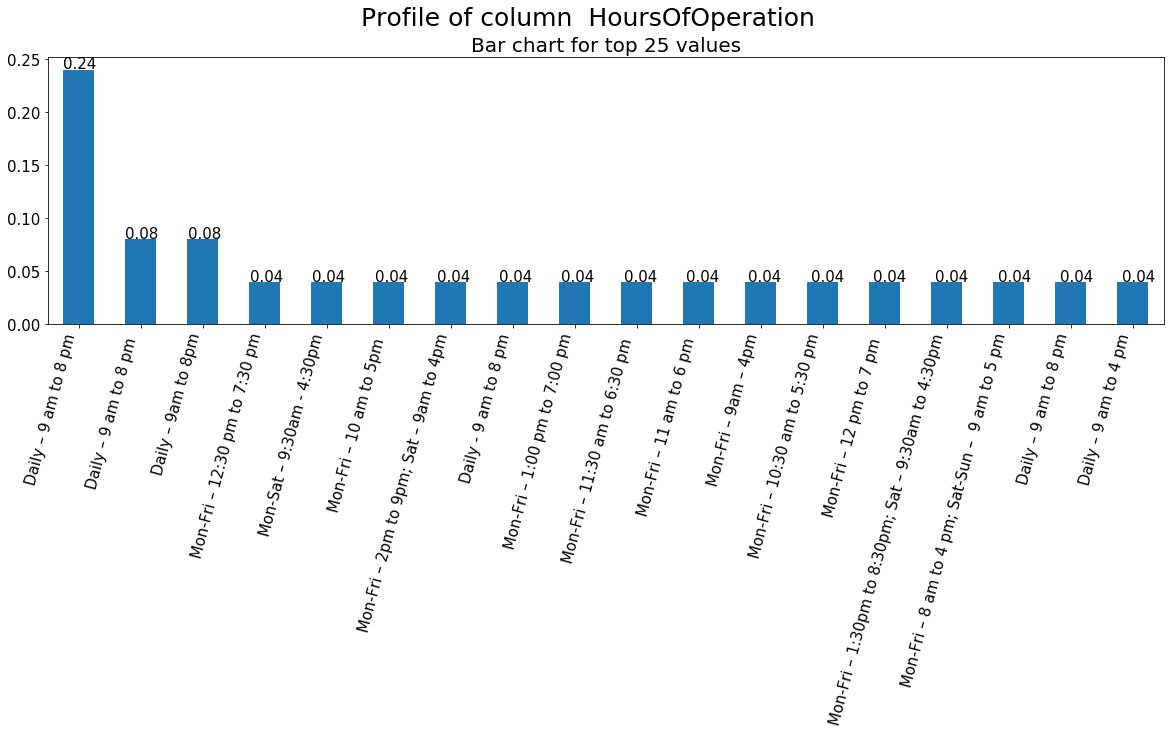

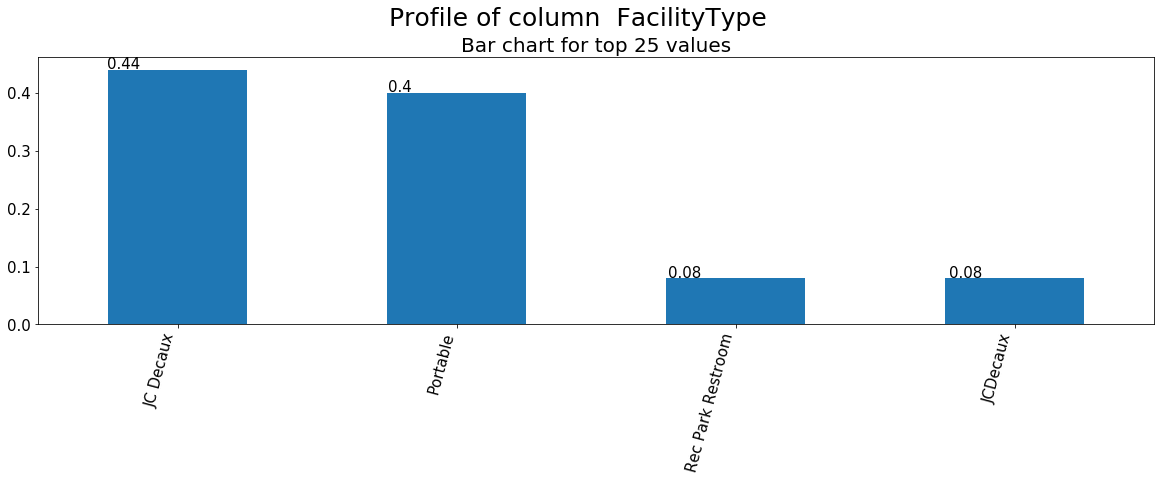

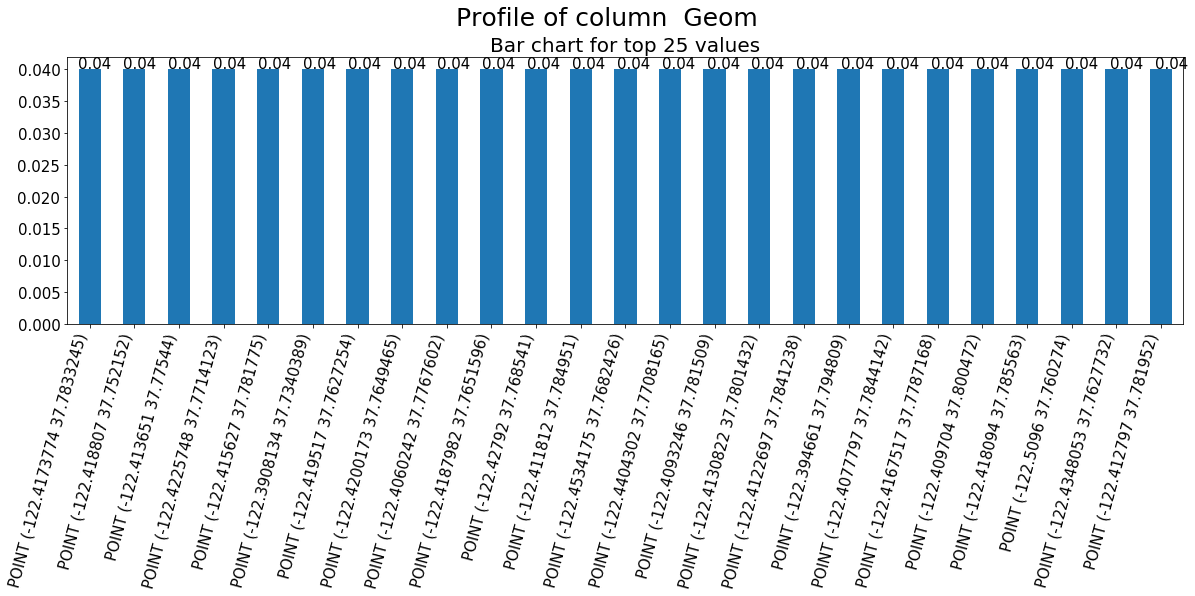

In [33]:
# Data graphs for visualizing objects
# get object columns which are not empty
obj_cols = [cols for cols in df.columns if is_string_dtype(df[cols]) and len(df[cols].dropna())>0]

iter_len = len(obj_cols)


# For each object column in the list
for x, col_name in enumerate(obj_cols):
    print(x+1, " of ", iter_len, " completed   ",  col_name)
    
    # Create a copy of the column values without nulls or NA
    no_null_col = df[col_name].dropna()

    values_freq_threshold = 25
    col_unique_count = df[col_name].nunique()
    
    # If unique values count is below the threshold value then store the details of unique values
    col_unique_vals = df[col_name].value_counts(normalize=True, sort=True)
    
    # Plot the graphs
    fig4 = plt.figure(figsize=(20,7))
    fig4.suptitle("Profile of column  " + col_name, fontsize=25)  #Title for the whole figure
    plt.subplots_adjust(wspace=0.4, hspace=0.35, bottom=0.35)

    ax1 = fig4.add_subplot(1,1,1)
    ax1.set_title("Bar chart for top 25 values", fontsize=20)
    plt.setp(ax1.get_xticklabels(), ha="right", rotation=45, fontsize=15)
    plt.setp(ax1.get_yticklabels(), ha="right", fontsize=15)
    
    col_unique_vals.head(values_freq_threshold).sort_values(ascending=False).plot.bar()
    plt.xticks(rotation=75)
    for p in ax1.patches:
        ax1.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.005, p.get_height() * 1.005), fontsize=15)
    
    fig4.suptitle("Profile of column  " + col_name, fontsize=25)  #Title for the whole figure
    fig_name = 'fig_' + col_name
    #fig4.savefig(fig_name, dpi= 50)
    plt.show()
    plt.close('all')


In [34]:

# The empty values threshold can be set to a lower/higher value depending on the size of the data sets 
threshold_perc = 0.75
col_vals_threshold = df.shape[0] * threshold_perc
null_vals_df = data_qlt_df[data_qlt_df['non_null_values'] < col_vals_threshold][['column_name', 'col_data_type', 'col_memory', 'non_null_values', '%_of_non_nulls', 'null_values', '%_of_nulls']]


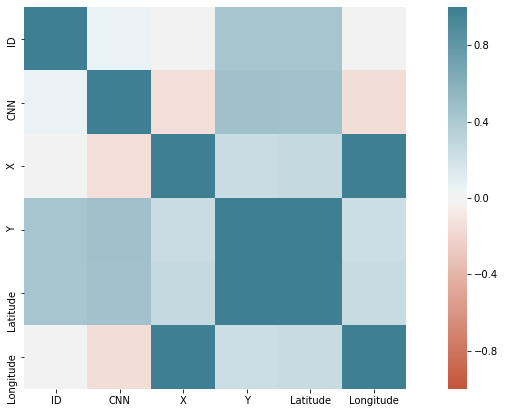

In [35]:
# Generating a correlation plot

f, ax = plt.subplots(figsize=(15, 10))
plt.subplots_adjust(bottom=0.35)
plt.autoscale()

corr_data = df.corr()
sns.heatmap(corr_data,
            mask=np.zeros_like(corr_data, dtype=np.bool), 
            cmap=sns.diverging_palette(20, 220, as_cmap=True),
            vmin=-1, vmax=1,
            square=True, 
            ax=ax)

# fig_name = 'fig_cor_plot.png'
# f.savefig(fig_name,  dpi=70)
plt.show()
plt.close('all')